In [1]:
# import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
#start = datetime.datetime(2000, 1, 1)
#end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [3]:
#df=pd.read_csv("data-2010.csv")
#df

In [13]:
d_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df = pd.read_csv('data-2010-vix.csv', parse_dates=['Date'], date_parser=d_parser)

C:\Users\HP\AppData\Local\Temp/ipykernel_6540/3888361686.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')


In [14]:
df

Date        VIX  Log Total Assets  \
0   2010-01-31  20.643158         14.629292   
1   2010-02-28  22.540000         14.634155   
2   2010-03-31  17.767391         14.647630   
3   2010-04-30  17.424286         14.660837   
4   2010-05-31  31.929500         14.664293   
..         ...        ...               ...   
115 2019-08-31  18.979091         15.143406   
116 2019-09-30  15.559000         15.152719   
117 2019-10-31  15.466522         15.194316   
118 2019-11-30  12.523500         15.212402   
119 2019-12-31  13.756667         15.230382   

     Log Currency in Circulation ($ Bil)  Effective Federal Funds Rate (%)  \
0                               6.825715                          0.110000   
1                               6.832180                          0.126429   
2                               6.837907                          0.164516   
3                               6.840604                          0.198333   
4                               6.843189                          0.200645   
..                                   ...                               ...   
115                             7.466865                          2.125806   
116                             7.474580                          2.043000   
117                             7.478444                          1.829677   
118                             7.487510                          1.553333   
119                             7.492348                          1.550968   

     Loss Function  
0       -33.735952  
1       -33.730959  
2       -34.859550  
3       -34.968581  
4       -31.492259  
..             ...  
115       0.068157  
116       0.167404  
117       0.079549  
118      -0.026577  
119       0.028774  

[120 rows x 6 columns]

In [15]:
df['Date_at_year_month'] = df['Date'].dt.strftime('%Y-%m')

In [16]:
df['Date_at_year_month']

0      2010-01
1      2010-02
2      2010-03
3      2010-04
4      2010-05
        ...   
115    2019-08
116    2019-09
117    2019-10
118    2019-11
119    2019-12
Name: Date_at_year_month, Length: 120, dtype: object

In [17]:
df.head()

Date        VIX  Log Total Assets  \
0 2010-01-31  20.643158         14.629292   
1 2010-02-28  22.540000         14.634155   
2 2010-03-31  17.767391         14.647630   
3 2010-04-30  17.424286         14.660837   
4 2010-05-31  31.929500         14.664293   

   Log Currency in Circulation ($ Bil)  Effective Federal Funds Rate (%)  \
0                             6.825715                          0.110000   
1                             6.832180                          0.126429   
2                             6.837907                          0.164516   
3                             6.840604                          0.198333   
4                             6.843189                          0.200645   

   Loss Function Date_at_year_month  
0     -33.735952            2010-01  
1     -33.730959            2010-02  
2     -34.859550            2010-03  
3     -34.968581            2010-04  
4     -31.492259            2010-05

In [18]:
column_names = {'Date_at_year_month':'DATE',
                'VIX':'V',
                'Log Total Assets': 'TA',
                'Log Currency in Circulation ($ Bil)':'CC',
                'Effective Federal Funds Rate (%)':'FFR', 
                'Loss Function':'LF'}

# rename columns
df = df.rename(columns = column_names)

df

Date          V         TA        CC       FFR         LF     DATE
0   2010-01-31  20.643158  14.629292  6.825715  0.110000 -33.735952  2010-01
1   2010-02-28  22.540000  14.634155  6.832180  0.126429 -33.730959  2010-02
2   2010-03-31  17.767391  14.647630  6.837907  0.164516 -34.859550  2010-03
3   2010-04-30  17.424286  14.660837  6.840604  0.198333 -34.968581  2010-04
4   2010-05-31  31.929500  14.664293  6.843189  0.200645 -31.492259  2010-05
..         ...        ...        ...       ...       ...        ...      ...
115 2019-08-31  18.979091  15.143406  7.466865  2.125806   0.068157  2019-08
116 2019-09-30  15.559000  15.152719  7.474580  2.043000   0.167404  2019-09
117 2019-10-31  15.466522  15.194316  7.478444  1.829677   0.079549  2019-10
118 2019-11-30  12.523500  15.212402  7.487510  1.553333  -0.026577  2019-11
119 2019-12-31  13.756667  15.230382  7.492348  1.550968   0.028774  2019-12

[120 rows x 7 columns]

In [10]:
#df['Date'] = pd.to_datetime(df['Date'], format ='%m-%Y')

In [19]:
df = df.set_index('DATE')
df

Date          V         TA        CC       FFR         LF
DATE                                                                   
2010-01 2010-01-31  20.643158  14.629292  6.825715  0.110000 -33.735952
2010-02 2010-02-28  22.540000  14.634155  6.832180  0.126429 -33.730959
2010-03 2010-03-31  17.767391  14.647630  6.837907  0.164516 -34.859550
2010-04 2010-04-30  17.424286  14.660837  6.840604  0.198333 -34.968581
2010-05 2010-05-31  31.929500  14.664293  6.843189  0.200645 -31.492259
...            ...        ...        ...       ...       ...        ...
2019-08 2019-08-31  18.979091  15.143406  7.466865  2.125806   0.068157
2019-09 2019-09-30  15.559000  15.152719  7.474580  2.043000   0.167404
2019-10 2019-10-31  15.466522  15.194316  7.478444  1.829677   0.079549
2019-11 2019-11-30  12.523500  15.212402  7.487510  1.553333  -0.026577
2019-12 2019-12-31  13.756667  15.230382  7.492348  1.550968   0.028774

[120 rows x 6 columns]

In [20]:
df = df.drop(['Date'], axis = 1)
df

V         TA        CC       FFR         LF
DATE                                                        
2010-01  20.643158  14.629292  6.825715  0.110000 -33.735952
2010-02  22.540000  14.634155  6.832180  0.126429 -33.730959
2010-03  17.767391  14.647630  6.837907  0.164516 -34.859550
2010-04  17.424286  14.660837  6.840604  0.198333 -34.968581
2010-05  31.929500  14.664293  6.843189  0.200645 -31.492259
...            ...        ...       ...       ...        ...
2019-08  18.979091  15.143406  7.466865  2.125806   0.068157
2019-09  15.559000  15.152719  7.474580  2.043000   0.167404
2019-10  15.466522  15.194316  7.478444  1.829677   0.079549
2019-11  12.523500  15.212402  7.487510  1.553333  -0.026577
2019-12  13.756667  15.230382  7.492348  1.550968   0.028774

[120 rows x 5 columns]

In [21]:
data = df
data

V         TA        CC       FFR         LF
DATE                                                        
2010-01  20.643158  14.629292  6.825715  0.110000 -33.735952
2010-02  22.540000  14.634155  6.832180  0.126429 -33.730959
2010-03  17.767391  14.647630  6.837907  0.164516 -34.859550
2010-04  17.424286  14.660837  6.840604  0.198333 -34.968581
2010-05  31.929500  14.664293  6.843189  0.200645 -31.492259
...            ...        ...       ...       ...        ...
2019-08  18.979091  15.143406  7.466865  2.125806   0.068157
2019-09  15.559000  15.152719  7.474580  2.043000   0.167404
2019-10  15.466522  15.194316  7.478444  1.829677   0.079549
2019-11  12.523500  15.212402  7.487510  1.553333  -0.026577
2019-12  13.756667  15.230382  7.492348  1.550968   0.028774

[120 rows x 5 columns]

In [22]:
data.isnull().sum()

V      0
TA     0
CC     0
FFR    0
LF     0
dtype: int64

In [23]:
#1st diff
data_diff = data.diff().dropna()
data_diff

V        TA        CC       FFR        LF
DATE                                                      
2010-02   1.896842  0.004863  0.006465  0.016429  0.004993
2010-03  -4.772609  0.013474  0.005727  0.038088 -1.128591
2010-04  -0.343106  0.013207  0.002697  0.033817 -0.109031
2010-05  14.505214  0.003456  0.002585  0.002312  3.476322
2010-06  -2.013136  0.000292  0.004139 -0.023978  2.135543
...            ...       ...       ...       ...       ...
2019-08   5.673182 -0.008099  0.001269 -0.277097  0.048684
2019-09  -3.420091  0.009313  0.007715 -0.082806  0.099247
2019-10  -0.092478  0.041597  0.003863 -0.213323 -0.087854
2019-11  -2.943022  0.018086  0.009067 -0.276344 -0.106127
2019-12   1.233167  0.017980  0.004837 -0.002366  0.055352

[119 rows x 5 columns]

In [24]:
#2nd diff
data_new = data_diff.diff().dropna()
data_new

V        TA        CC       FFR        LF
DATE                                                      
2010-03  -6.669451  0.008611 -0.000738  0.021659 -1.133584
2010-04   4.429503 -0.000267 -0.003030 -0.004270  1.019559
2010-05  14.848320 -0.009751 -0.000112 -0.031505  3.585353
2010-06 -16.518351 -0.003164  0.001554 -0.026290 -1.340778
2010-07  -2.337989 -0.002388 -0.000532  0.029892 -2.219644
...            ...       ...       ...       ...       ...
2019-08   8.203273  0.001927 -0.003976 -0.302333  0.109370
2019-09  -9.093273  0.017413  0.006447  0.194290  0.050563
2019-10   3.327613  0.032283 -0.003852 -0.130516 -0.187102
2019-11  -2.850543 -0.023511  0.005203 -0.063022 -0.018272
2019-12   4.176188 -0.000105 -0.004229  0.273978  0.161478

[118 rows x 5 columns]

In [25]:
X = data_new["V"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["LF"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -6.454731
p-value: 0.000000
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582
Reject Ho - Time Series is Stationary
ADF Statistic: -4.041664
p-value: 0.001207
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -3.291547
p-value: 0.015261
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Reject Ho - Time Series is Stationary
ADF Statistic: -5.228430
p-value: 0.000008
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Reject Ho - Time Series is Stationary
ADF Statistic: -8.210825
p-value: 0.000000
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary


In [26]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

V        TA        CC       FFR        LF
DATE                                                     
2010-01 -3.085200  0.039296  0.010055  0.011480 -2.147003
2010-02 -1.189226  0.040507  0.014970 -0.023871 -2.373494
2010-03 -6.475241  0.081160  0.024597 -0.032524 -4.074747
2010-04 -7.031988  0.099334  0.023110  0.001195 -4.431034
2010-05  8.584125  0.023735 -0.004478  0.076759 -0.467474
...           ...       ...       ...       ...       ...
2019-08  4.440775 -0.088438  0.021782 -0.141568  0.880791
2019-09  1.310761 -0.089629  0.035152 -0.239133  0.055167
2019-10  1.478475 -0.072967  0.059144 -0.410979 -1.602473
2019-11 -0.747364 -0.085576  0.096762 -0.710110 -3.450363
2019-12  0.414526 -0.072670  0.099923 -0.721700 -3.864914

[120 rows x 5 columns]

In [27]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

V    TA    CC   FFR    LF
V    1.00  0.11 -0.08  0.13 -0.12
TA   0.11  1.00  0.22 -0.46  0.54
CC  -0.08  0.22  1.00  0.92  0.68
FFR  0.13 -0.46  0.92  1.00 -0.41
LF  -0.12  0.54  0.68 -0.41  1.00

In [28]:
# !pip install pingouin
import pingouin
df.pcorr().round(2)

V    TA    CC   FFR    LF
V    1.00  0.11 -0.08  0.13 -0.12
TA   0.11  1.00  0.22 -0.46  0.54
CC  -0.08  0.22  1.00  0.92  0.68
FFR  0.13 -0.46  0.92  1.00 -0.41
LF  -0.12  0.54  0.68 -0.41  1.00

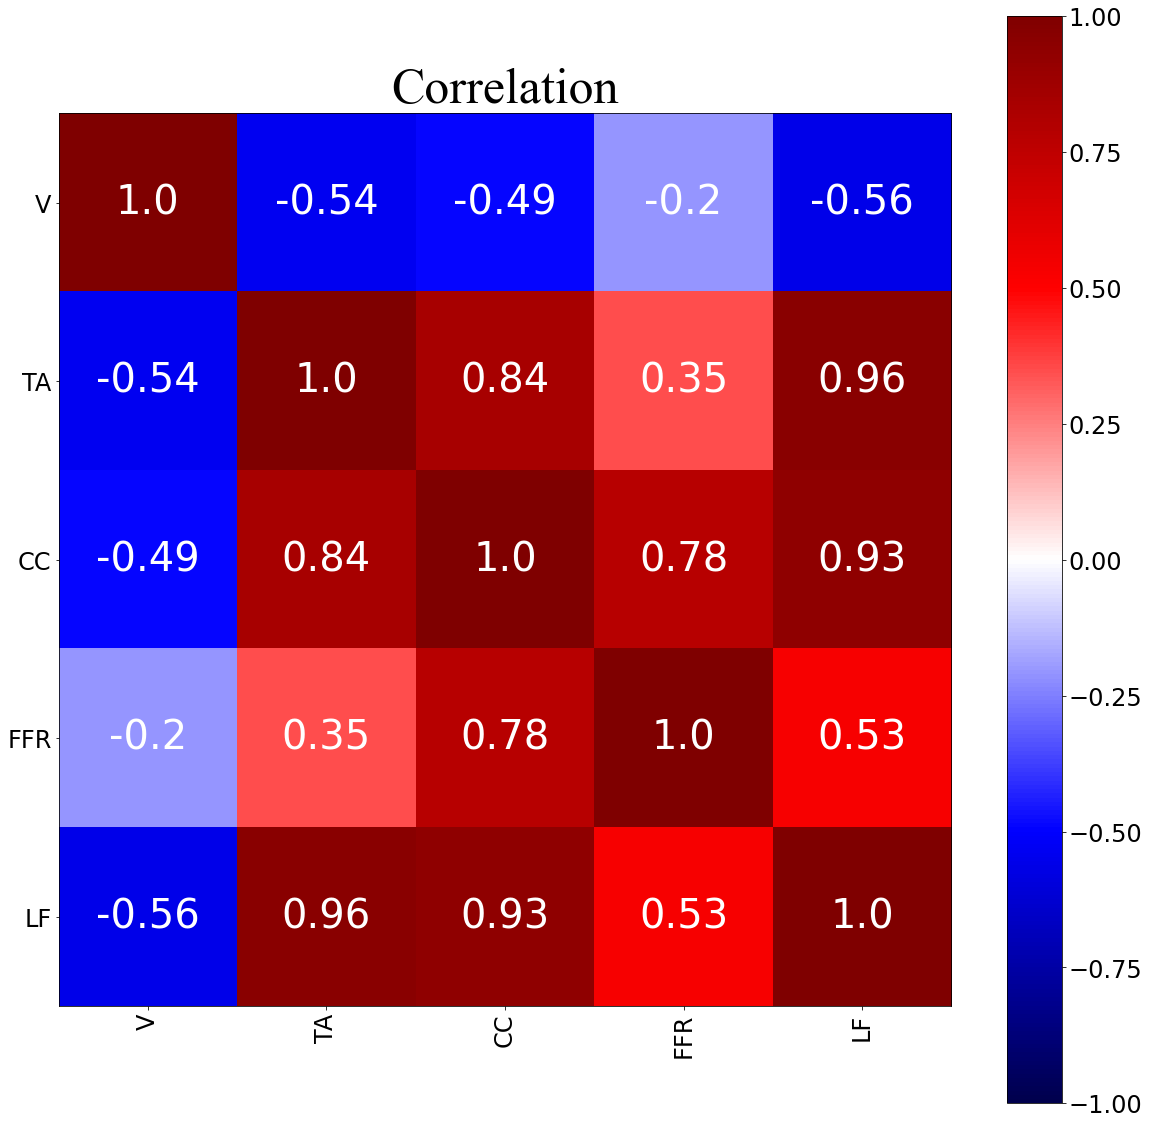

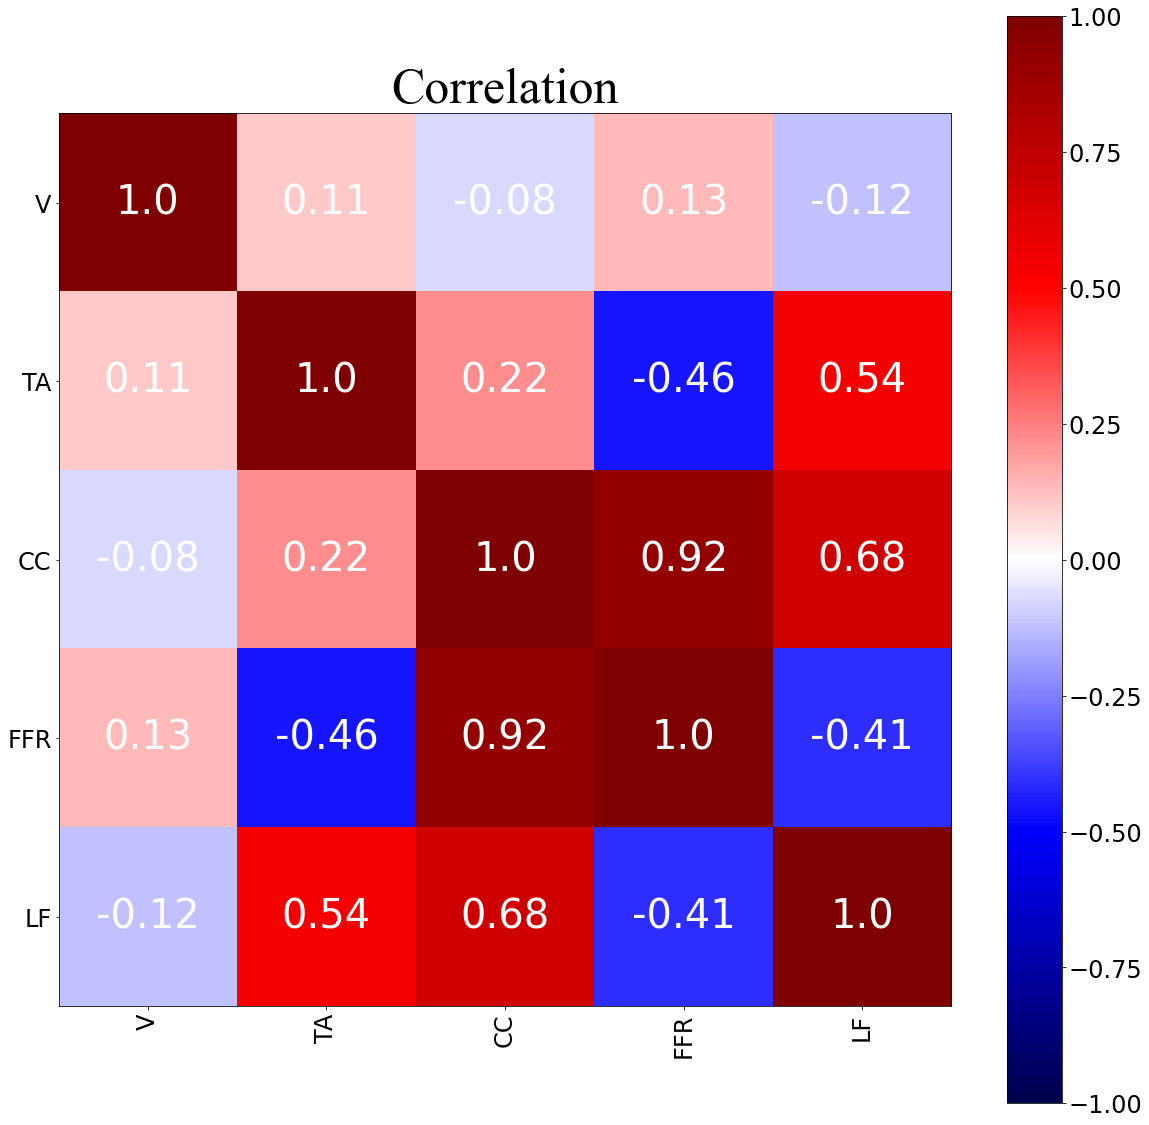

In [29]:
from datlib.plots import *
corr_matrix_heatmap(df.corr(), 
                    save_fig = False, 
                    pp = None)
corr_matrix_heatmap(df.pcorr(), save_fig = False, pp = None)

In [30]:
residuals

V        TA        CC       FFR        LF
DATE                                                     
2010-01 -3.085200  0.039296  0.010055  0.011480 -2.147003
2010-02 -1.189226  0.040507  0.014970 -0.023871 -2.373494
2010-03 -6.475241  0.081160  0.024597 -0.032524 -4.074747
2010-04 -7.031988  0.099334  0.023110  0.001195 -4.431034
2010-05  8.584125  0.023735 -0.004478  0.076759 -0.467474
...           ...       ...       ...       ...       ...
2019-08  4.440775 -0.088438  0.021782 -0.141568  0.880791
2019-09  1.310761 -0.089629  0.035152 -0.239133  0.055167
2019-10  1.478475 -0.072967  0.059144 -0.410979 -1.602473
2019-11 -0.747364 -0.085576  0.096762 -0.710110 -3.450363
2019-12  0.414526 -0.072670  0.099923 -0.721700 -3.864914

[120 rows x 5 columns]

In [31]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

V    TA    CC   FFR    LF
V     NaN  0.24  0.40  0.14  0.19
TA   0.24   NaN  0.01  0.00  0.00
CC   0.40  0.01   NaN  0.00  0.00
FFR  0.14  0.00  0.00   NaN  0.00
LF   0.19  0.00  0.00  0.00   NaN

In [32]:
import pingouin
from pgmpy.estimators import PC
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings("ignore")
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx

In [33]:
## Estimating a Directed Acyclic Graph
p_val = .01
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys())-2


model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

  0%|          | 0/3 [00:00<?, ?it/s]

OutEdgeView([('FFR', 'LF'), ('V', 'LF'), ('TA', 'FFR'), ('CC', 'FFR'), ('CC', 'TA')])

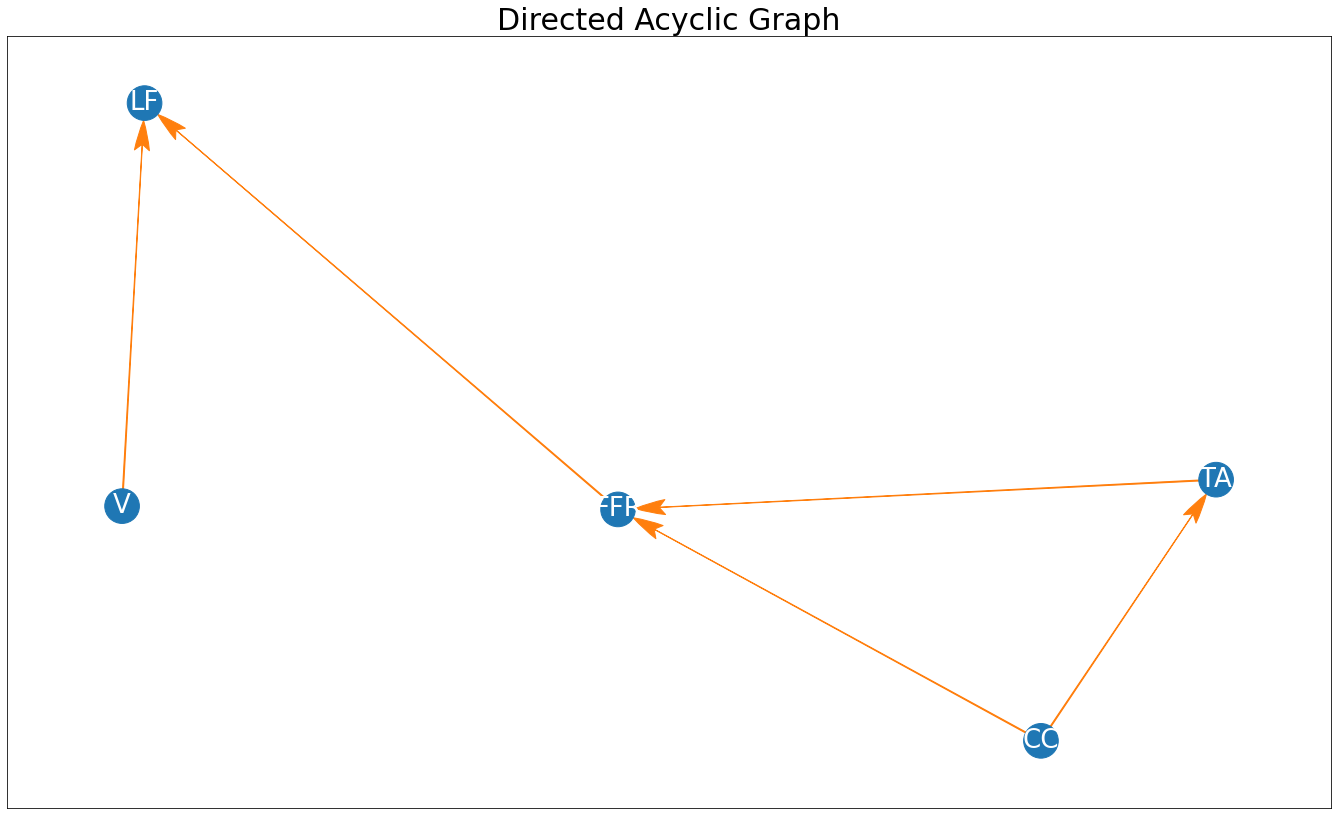

In [34]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

keep control: V
('FFR', 'LF') ['V']
keep control: FFR
('V', 'LF') ['FFR']
keep control: CC
('TA', 'FFR') ['CC']
keep control: TA
('CC', 'FFR') ['TA']
('CC', 'TA') []


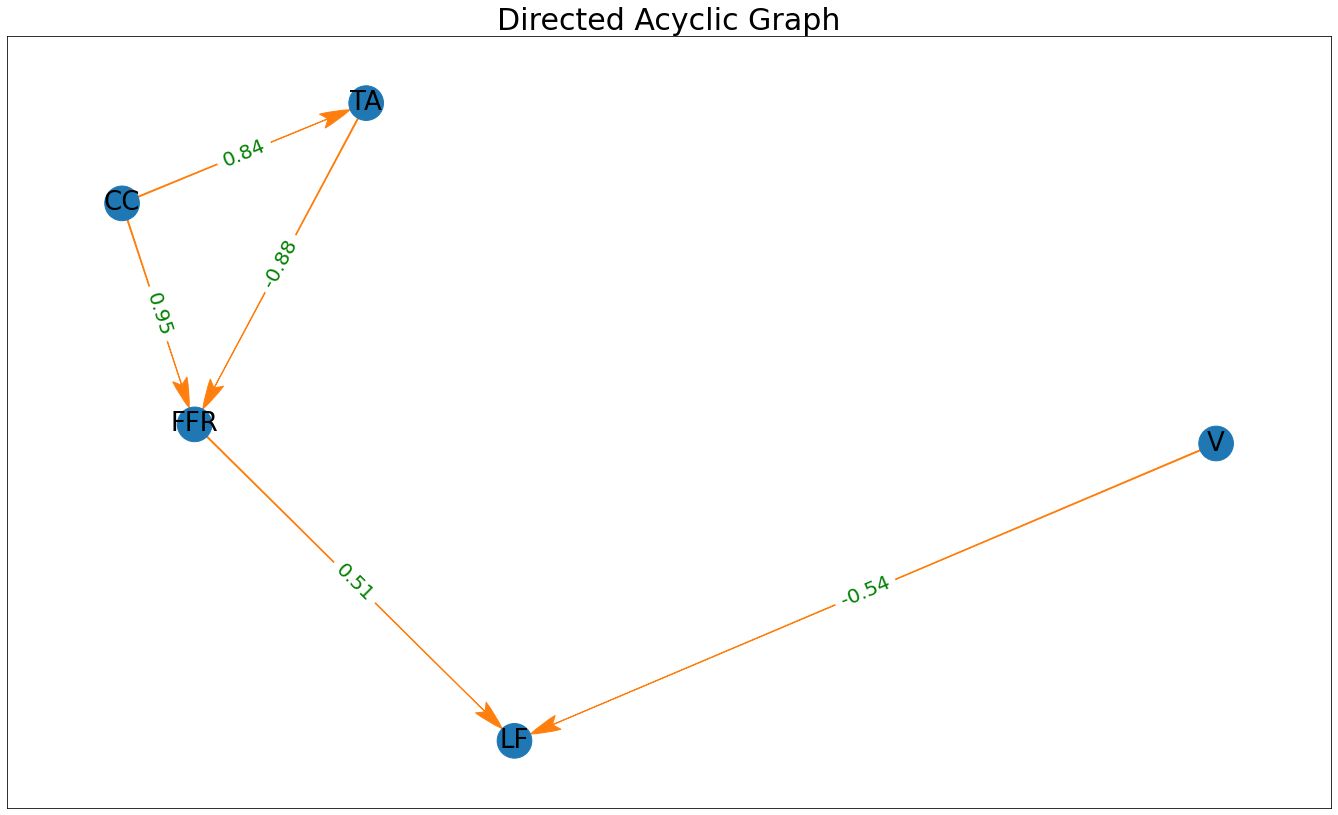

In [35]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")

In [36]:
data = df

In [37]:
def firstLetterWord(str, num_chars = 3):
 
    result = ""
 
    # Traverse the string.
    v = True
    for i in range(len(str)):
         
        # If it is space, set v as true.
        if (str[i] == ' '):
            v = True
 
        # Else check if v is true or not.
        # If true, copy character in output
        # string and set v as false.
        elif (str[i] != ' ' and v == True):
            result += (str[i:i+num_chars])
            v = False
 
    return result

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

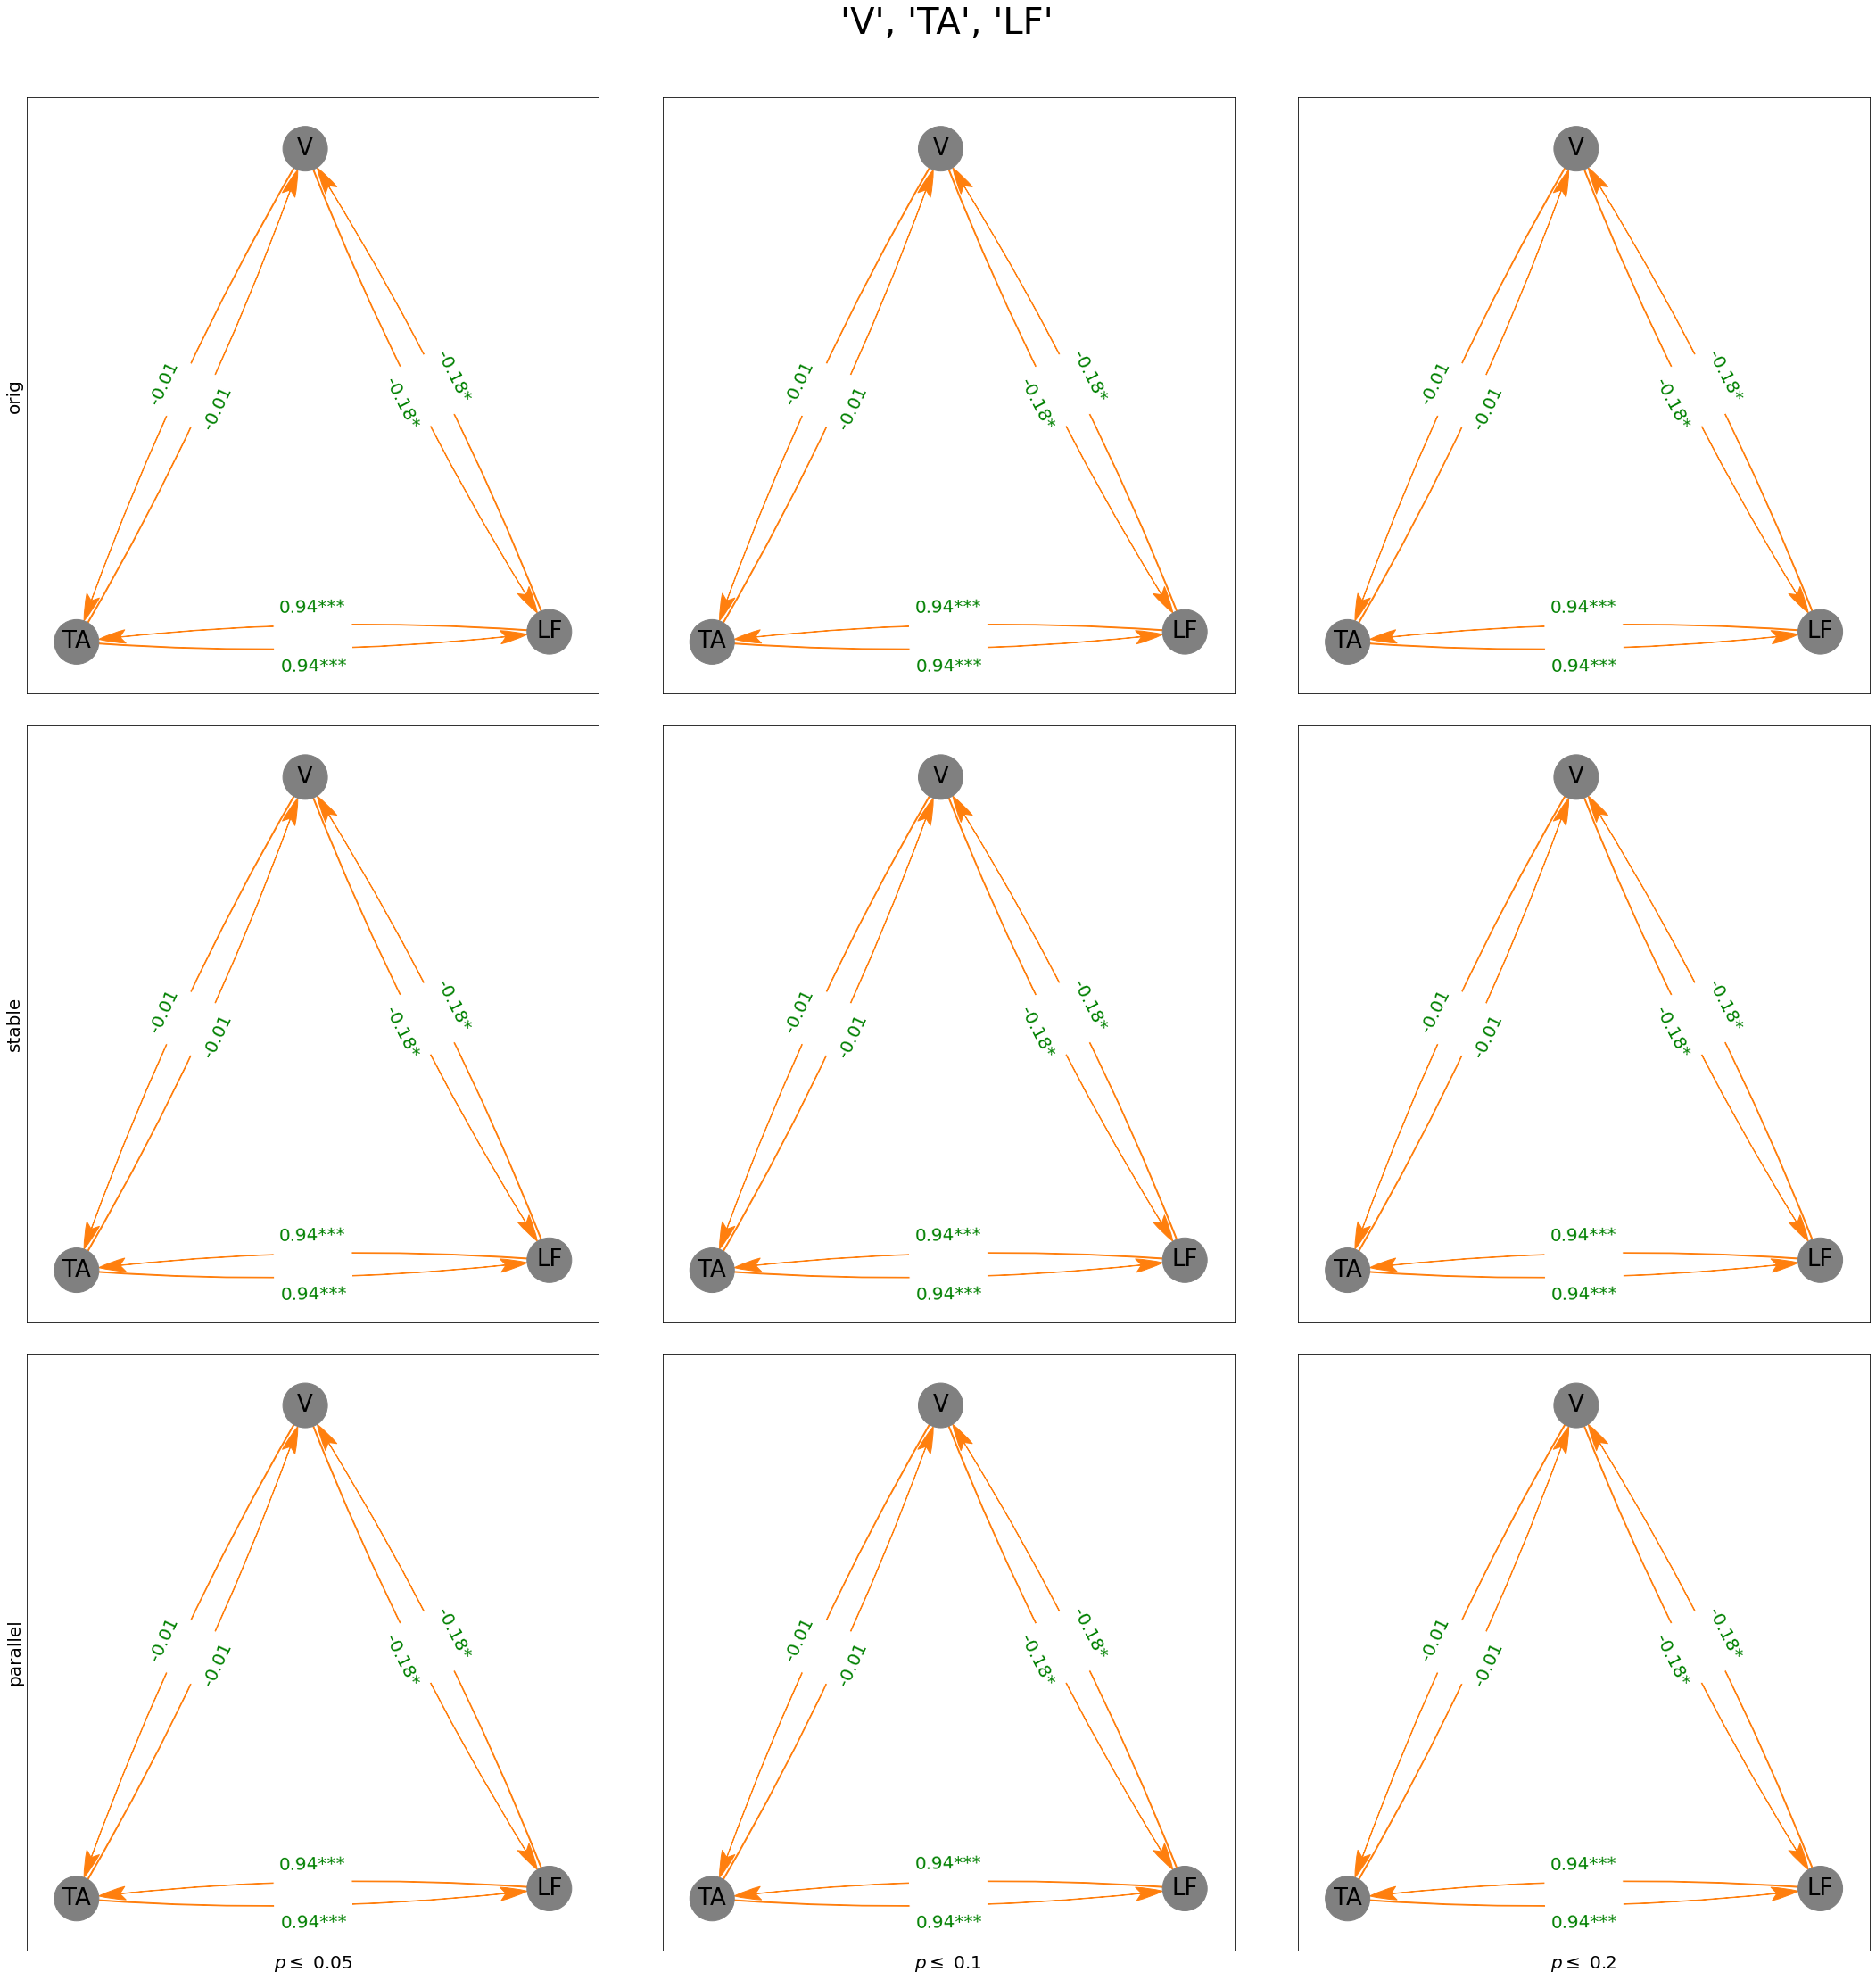

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

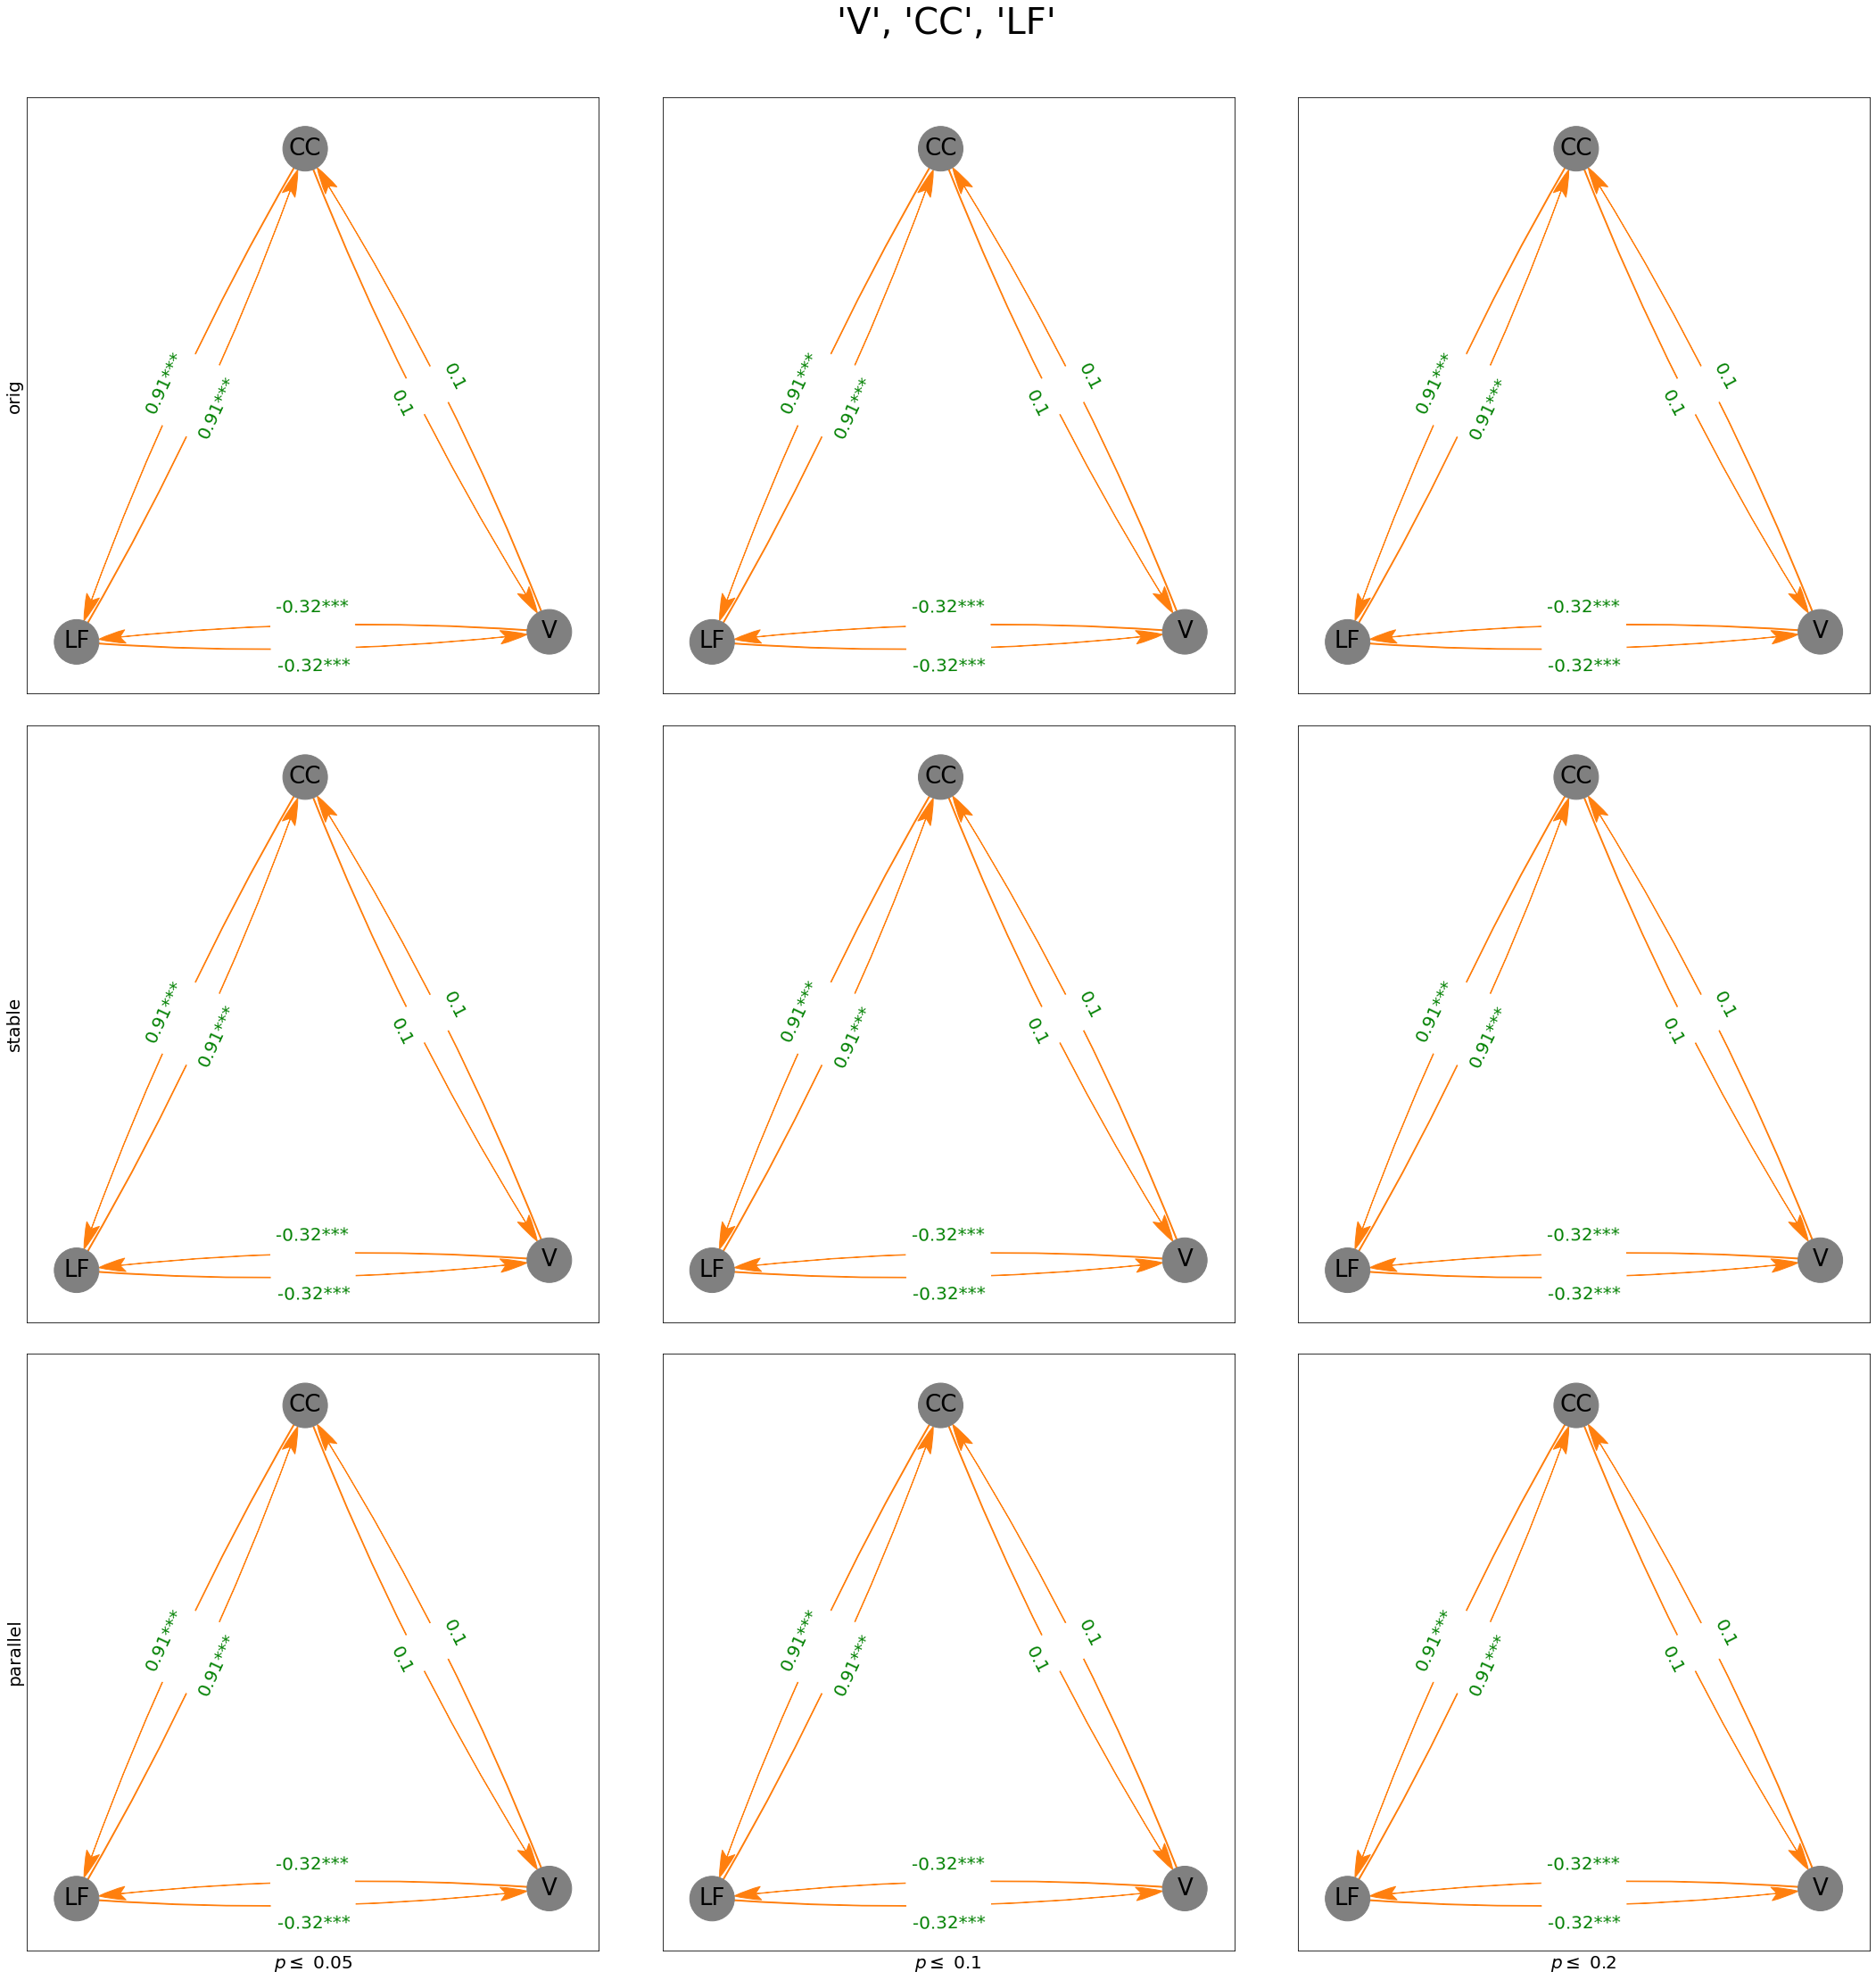

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

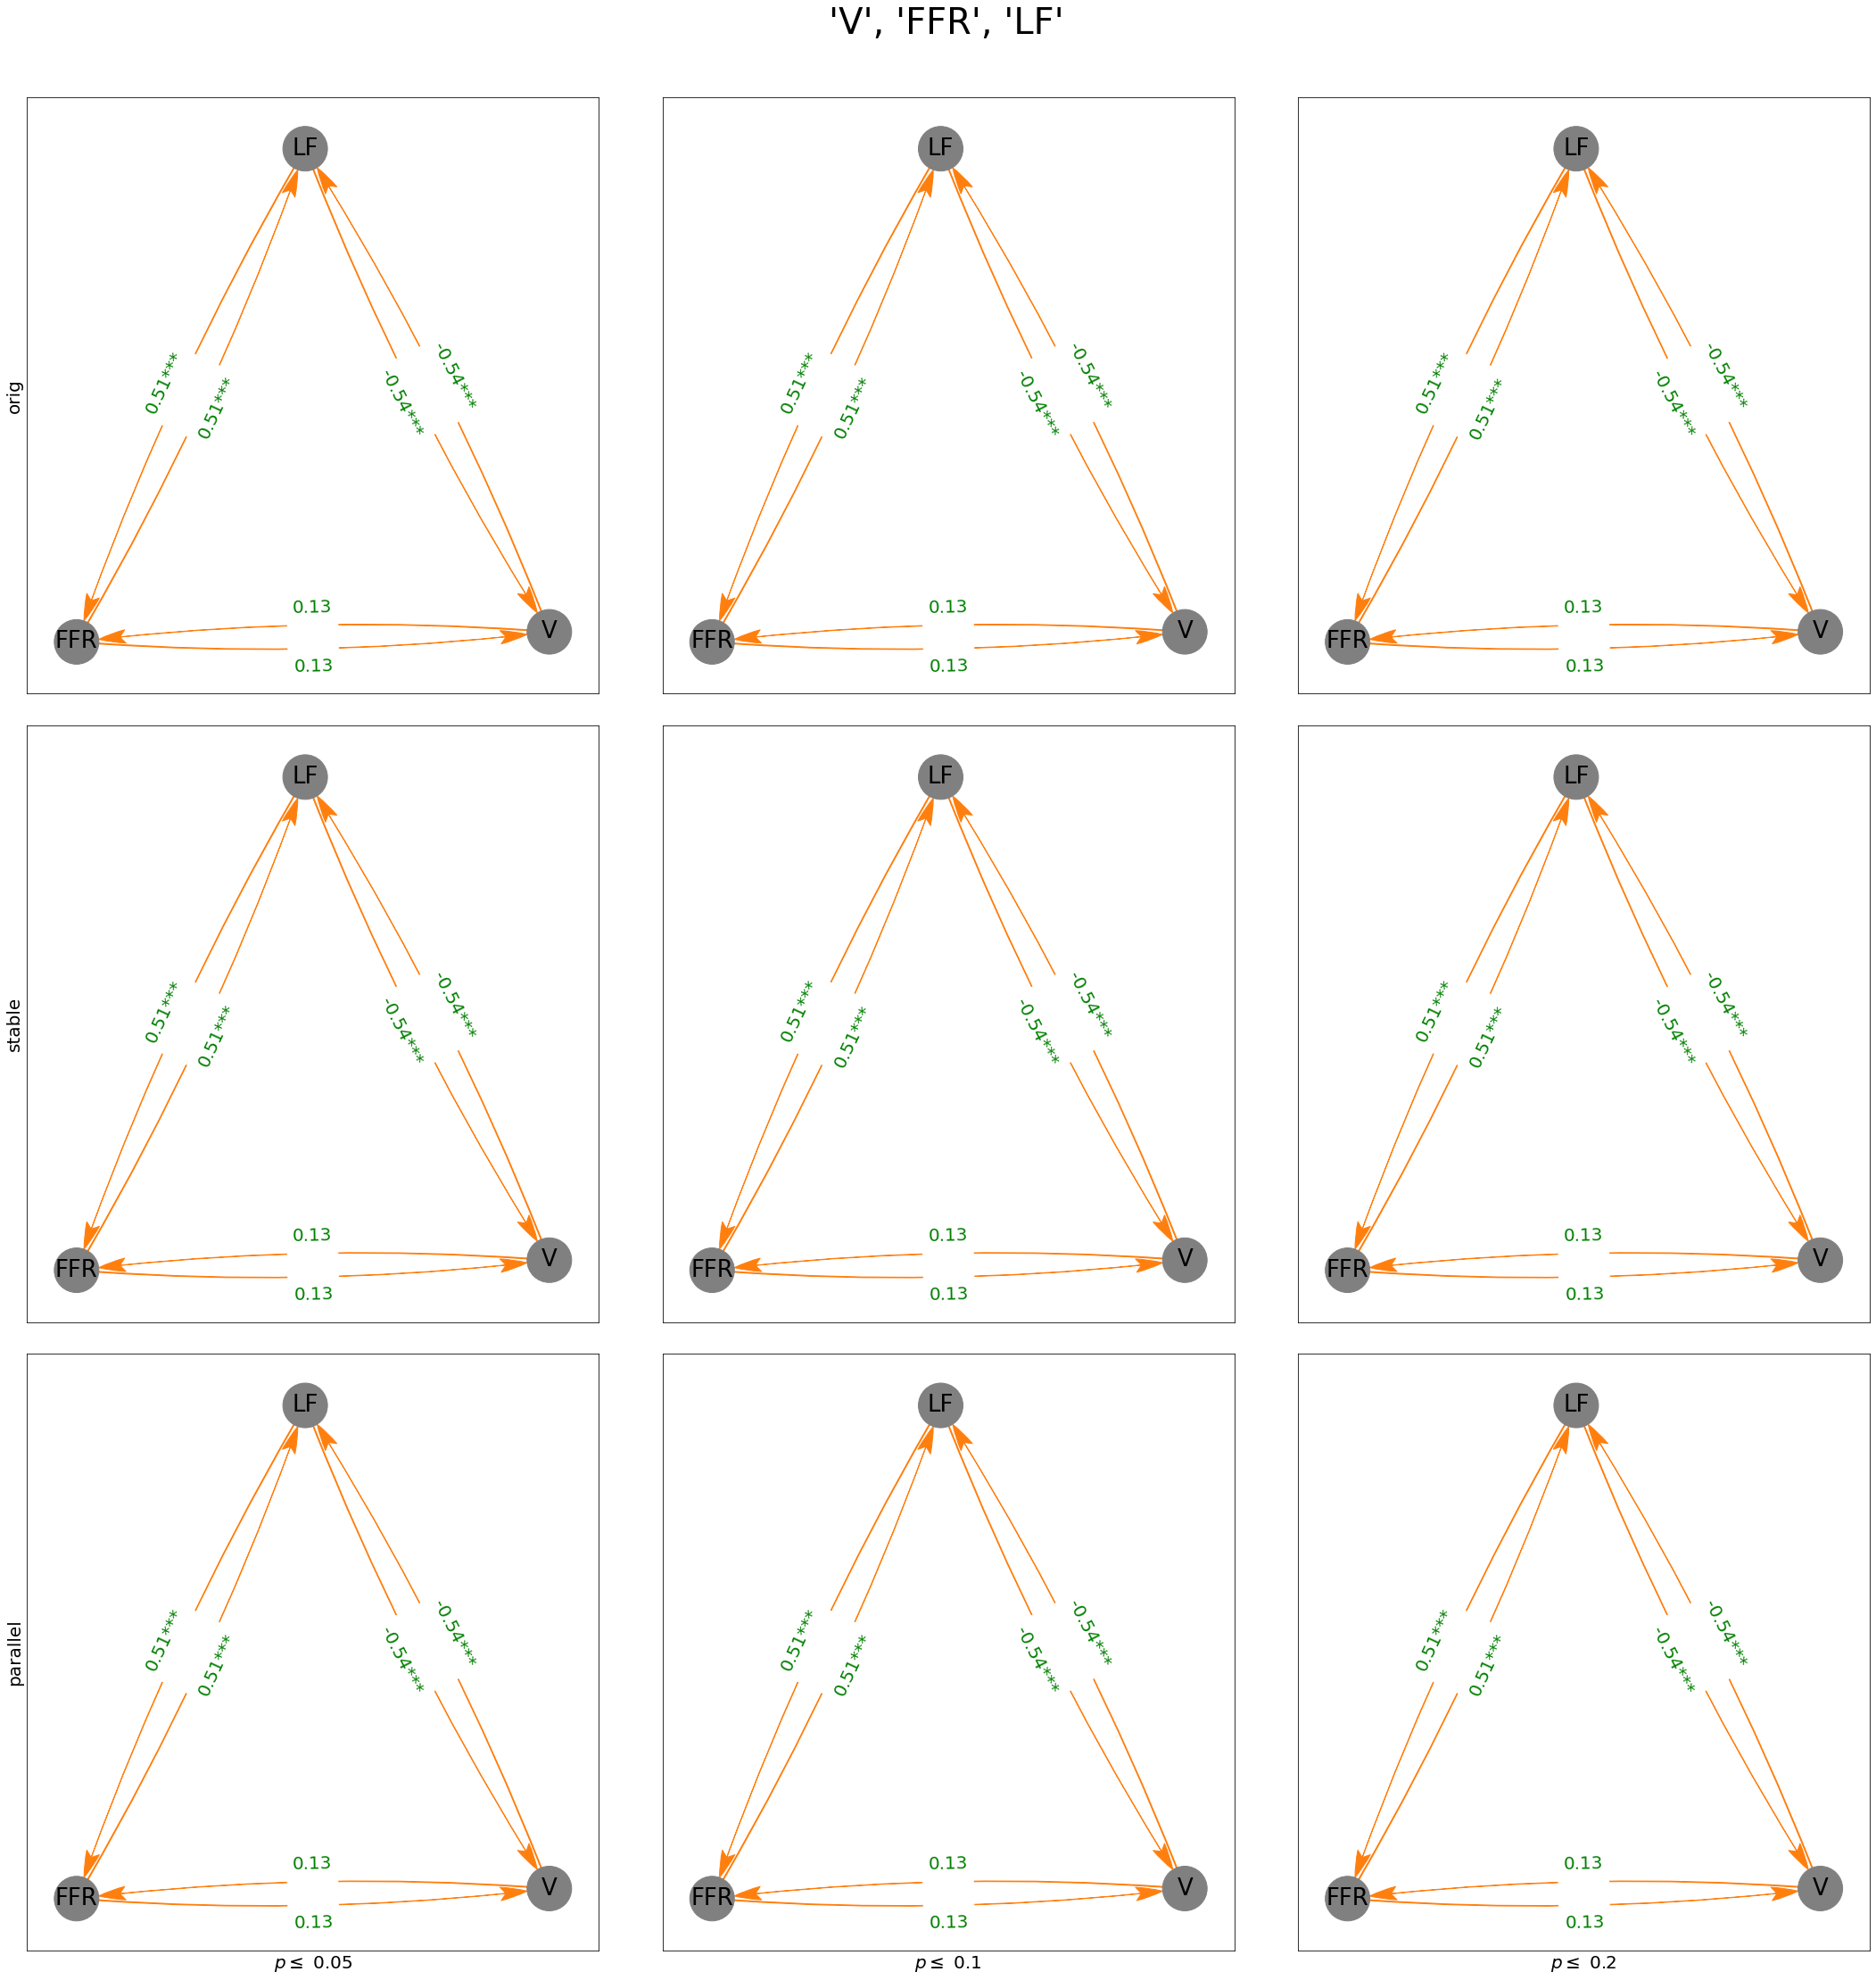

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

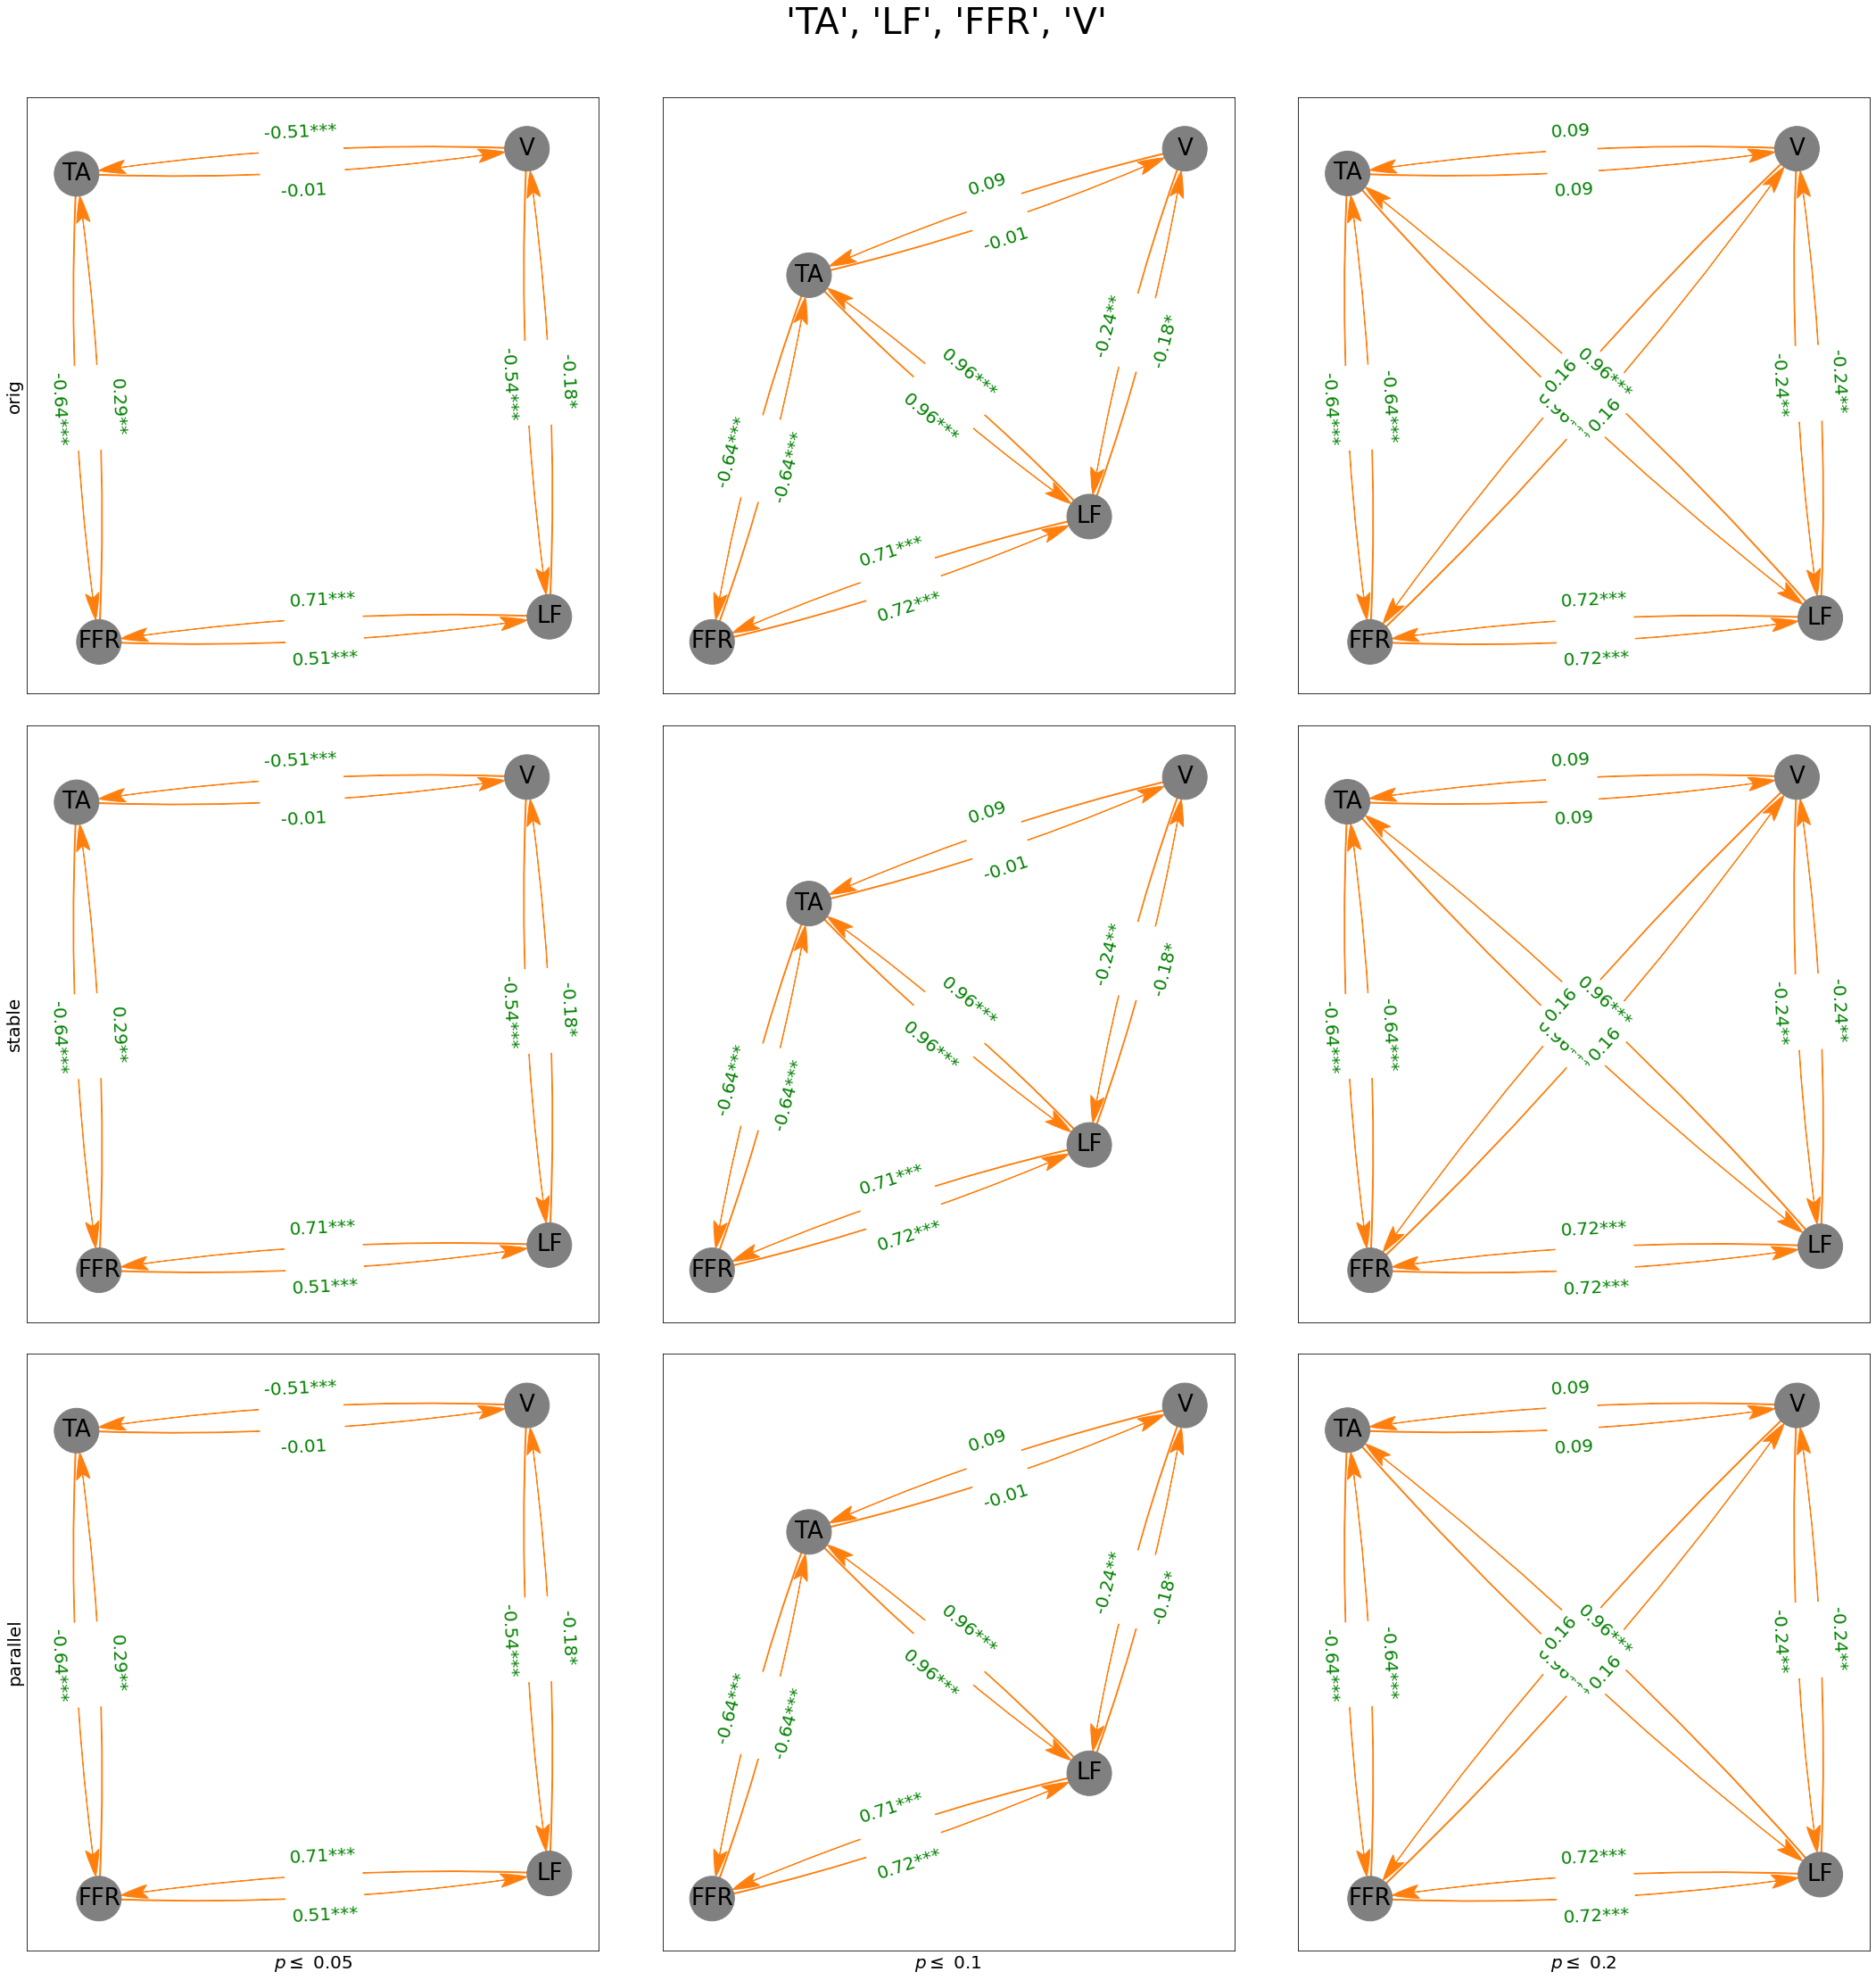

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

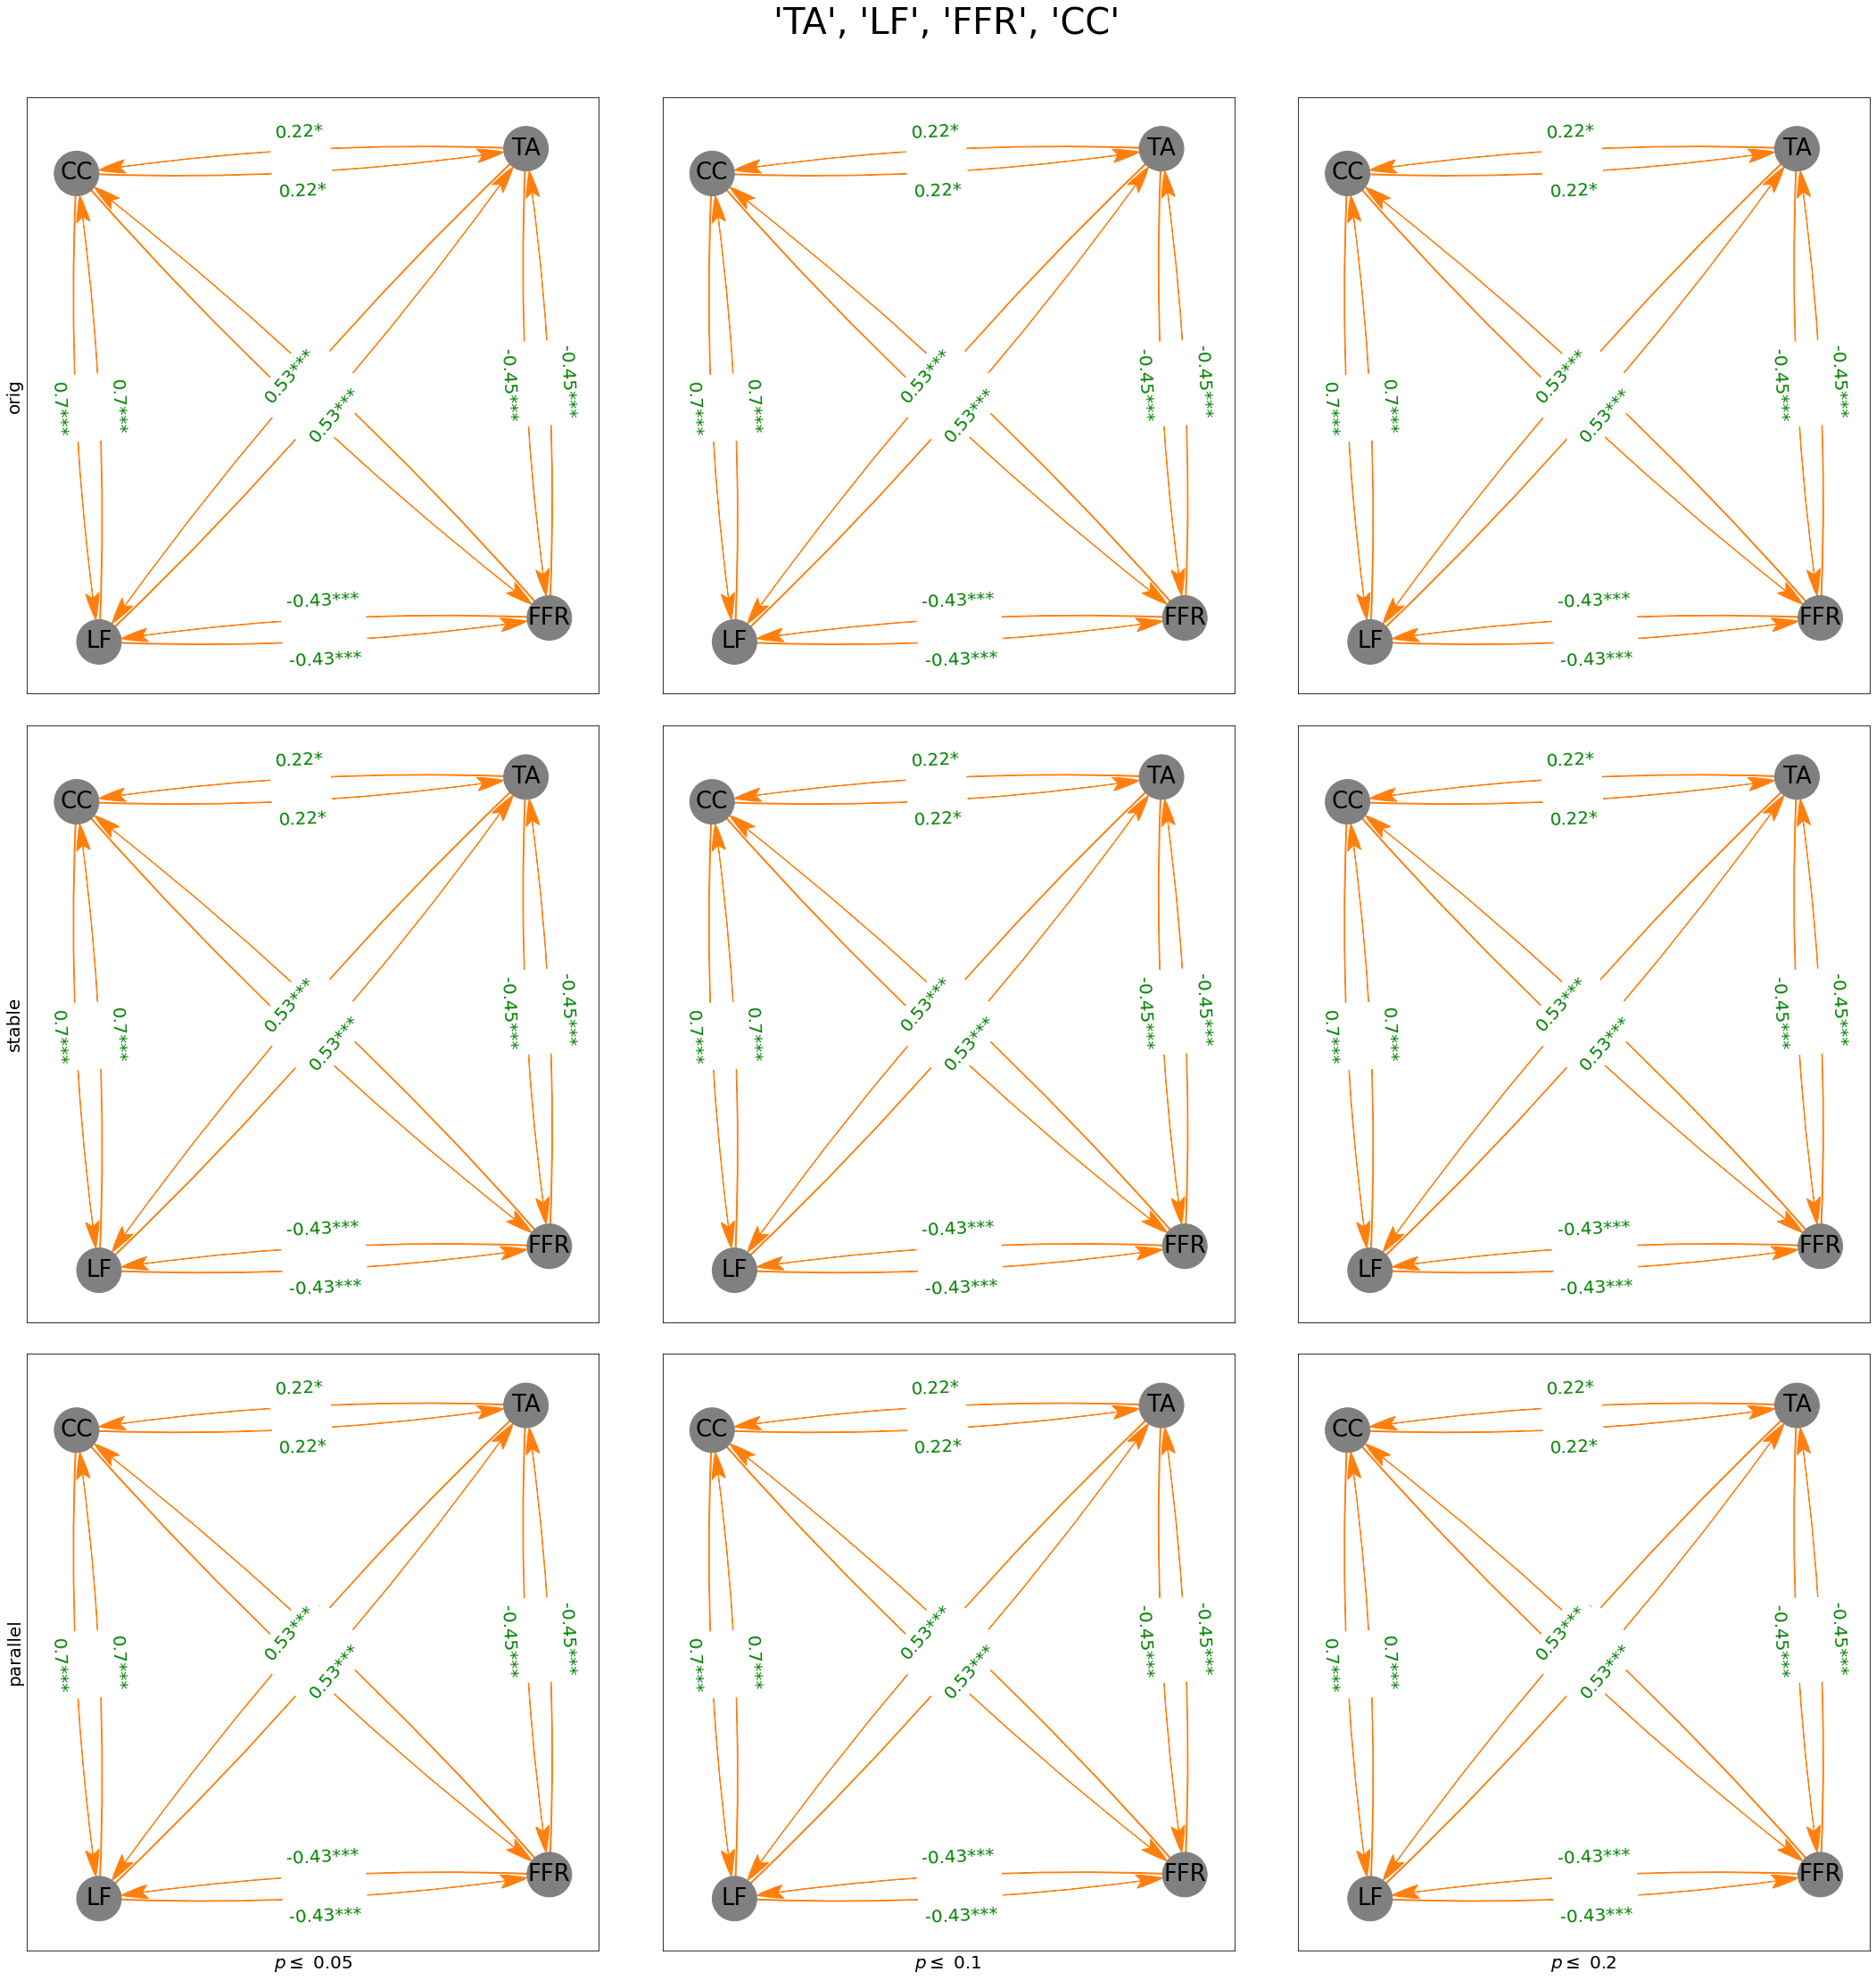

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

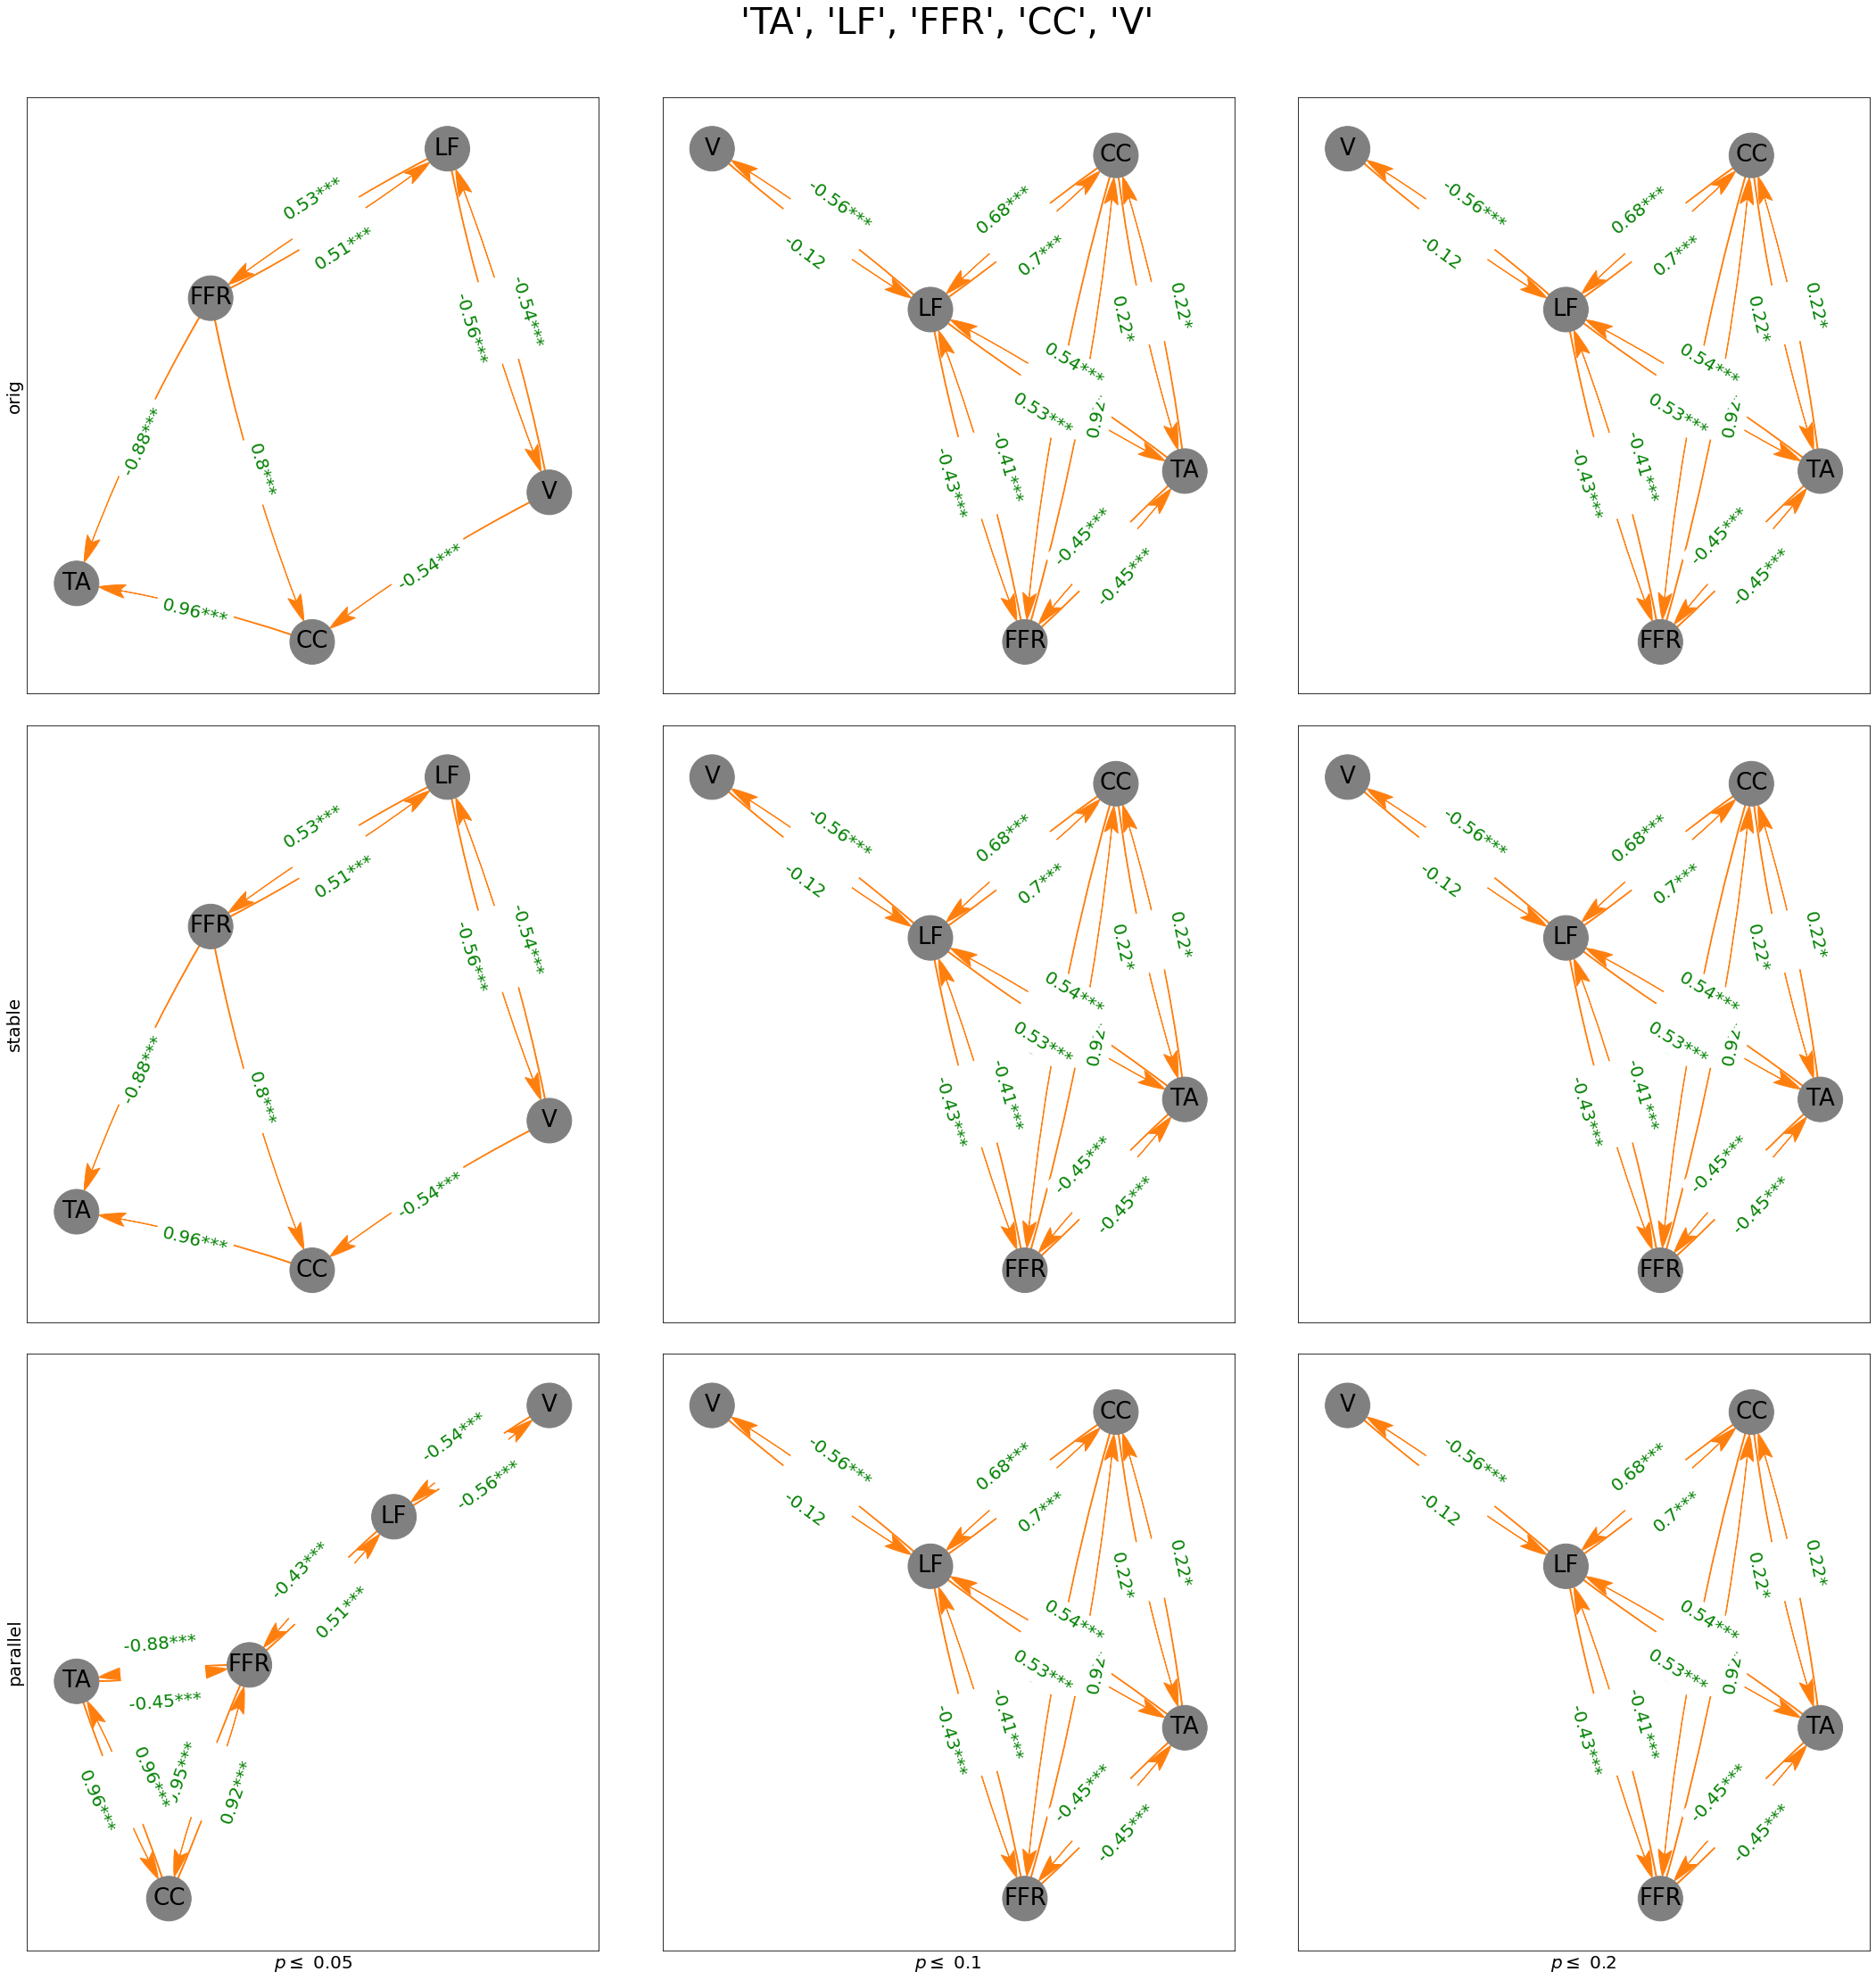

OutEdgeView([('LF', 'CC'), ('LF', 'FFR'), ('LF', 'V'), ('LF', 'TA'), ('CC', 'LF'), ('CC', 'FFR'), ('CC', 'TA'), ('FFR', 'TA'), ('FFR', 'CC'), ('FFR', 'LF'), ('TA', 'FFR'), ('TA', 'CC'), ('TA', 'LF'), ('V', 'LF')])

In [38]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["V", "TA", "LF"],
                  1:["V", "CC", "LF"],
                  2:["V", "FFR", "LF"],
                  3:["TA", "LF", "FFR", "V"],
                  4:["TA", "LF", "FFR", "CC"],
                  5:["TA", "LF", "FFR", "CC","V"],}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges